Stopping search: maximum iterations reached --> 200
Stopping search: Swarm best position change less than 1e-06
Stopping search: Swarm best objective change less than 1e-08

Settaggio: P=100, niter=200, K=1.2, epsilon1=1e-05, lambda=0.3
- Pesi del portafoglio: [0. 0. 0. 0. 0. 1. 0. 0.]
- Rendimento atteso: 0.0033
- Volatilità attesa: 0.0181

Settaggio: P=120, niter=300, K=1.5, epsilon1=1e-06, lambda=0.5
- Pesi del portafoglio: [0.         0.         0.98508982 0.         0.0149102  0.
 0.         0.        ]
- Rendimento atteso: 0.0013
- Volatilità attesa: 0.0304

Settaggio: P=150, niter=400, K=2.0, epsilon1=1e-07, lambda=0.7
- Pesi del portafoglio: [0.         0.         0.32037974 0.19078907 0.48669722 0.
 0.         0.00213386]
- Rendimento atteso: 0.0042
- Volatilità attesa: 0.0328


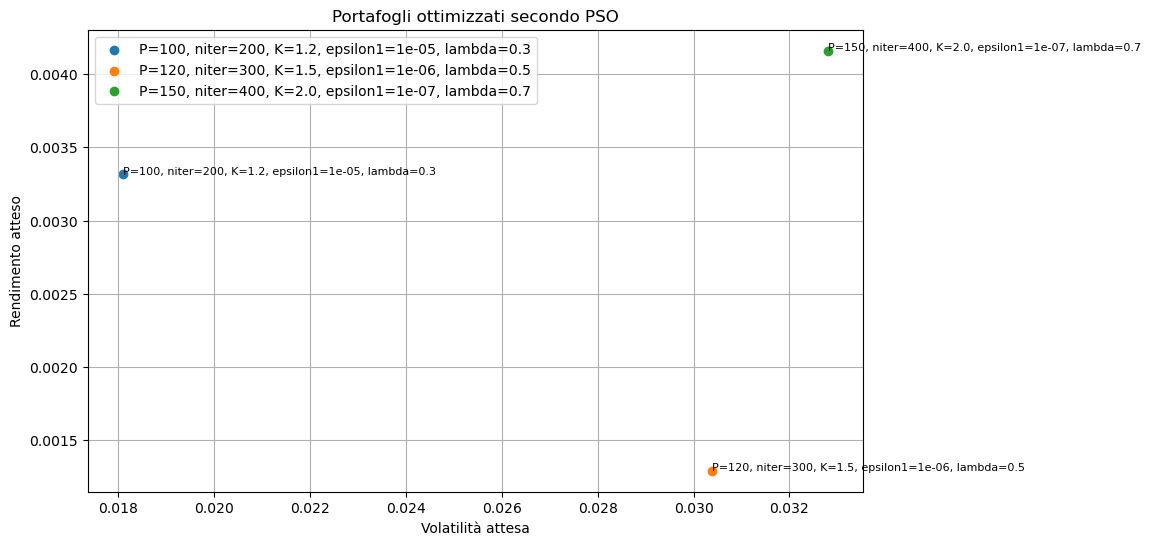

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyswarm import pso

# Caricamento dei dati
file_rendimenti = "log_returns.xlsx"
try:
    dati_rendimenti = pd.read_excel(file_rendimenti)
    log_returns = dati_rendimenti.iloc[:200, 1:]  
except FileNotFoundError:
    print(f"Errore: Il file '{file_rendimenti}' non è stato trovato.")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento del file: {e}")
    exit() 

# Parametri di input
mean_returns = log_returns.mean().values  # Media dei rendimenti
cov_matrix = log_returns.cov().values  # Matrice di covarianza
n_assets = len(mean_returns)  # Numero di attività

# Funzioni obiettivo
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

# Funzione obiettivo con penalità
def mean_variance_objective(weights, mean_returns, cov_matrix, lambda_):
    port_return = portfolio_return(weights, mean_returns)
    port_variance = portfolio_variance(weights, cov_matrix)
    penalty_budget = 1e5 * (np.abs(np.sum(weights) - 1) ** 2)  # Somma pesi = 1
    penalty_bounds = 1e5 * np.sum(np.maximum(0, -weights) + np.maximum(0, weights - 1))  # Limiti pesi [0,1]
    return lambda_ * port_variance - (1 - lambda_) * port_return + penalty_budget + penalty_bounds

# Ottimizzazione con PSO
def optimize_portfolio(mean_returns, cov_matrix, P, niter, K, epsilon1, lambda_):
    bounds = [(0, 1) for _ in range(n_assets)]  # Pesi limitati a [0, 1]
    weights, _ = pso(
        mean_variance_objective,
        [0] * n_assets,  # Limiti inferiori
        [1] * n_assets,  # Limiti superiori
        args=(mean_returns, cov_matrix, lambda_),
        swarmsize=P,
        maxiter=niter,
        phip=K,
        phig=K,
        minstep=epsilon1,
        debug=False
    )
    return weights

# Configurazioni PSO
settings = [
    {"P": 100, "niter": 200, "K": 1.2, "epsilon1": 1e-05, "lambda_": 0.3},
    {"P": 120, "niter": 300, "K": 1.5, "epsilon1": 1e-06, "lambda_": 0.5},
    {"P": 150, "niter": 400, "K": 2.0, "epsilon1": 1e-07, "lambda_": 0.7},
]

# Esecuzione e risultati
optimized_portfolios = {}
for setting in settings:
    P, niter, K, epsilon1, lambda_ = setting.values()
    weights = optimize_portfolio(mean_returns, cov_matrix, P, niter, K, epsilon1, lambda_)
    portfolio_ret = portfolio_return(weights, mean_returns)
    portfolio_vol = np.sqrt(portfolio_variance(weights, cov_matrix))
    optimized_portfolios[f"P={P}, niter={niter}, K={K}, epsilon1={epsilon1}, lambda={lambda_}"] = {
        "weights": weights,
        "return": portfolio_ret,
        "volatility": portfolio_vol,
    }

# Visualizzazione dei risultati
for key, values in optimized_portfolios.items():
    print(f"\nSettaggio: {key}")
    print(f"- Pesi del portafoglio: {values['weights']}")
    print(f"- Rendimento atteso: {values['return']:.4f}")
    print(f"- Volatilità attesa: {values['volatility']:.4f}")

# Grafico
plt.figure(figsize=(10, 6))
for key, values in optimized_portfolios.items():
    plt.scatter(values["volatility"], values["return"], label=key)
    plt.annotate(key, (values["volatility"], values["return"]), fontsize=8)
plt.xlabel("Volatilità attesa")
plt.ylabel("Rendimento atteso")
plt.title("Portafogli ottimizzati secondo PSO")
plt.legend()
plt.grid()
plt.show()

Stopping search: Swarm best position change less than 0.0001

Settaggio: P=40, niter=1000, lambda_=0.5, epsilon1=0.0001
- Media rendimento out-of-sample: 0.0025
- Varianza rendimento out-of-sample: 0.0002
Stopping search: Swarm best objective change less than 1e-08

Settaggio: P=50, niter=2000, lambda_=0.7, epsilon1=1e-05
- Media rendimento out-of-sample: 0.0029
- Varianza rendimento out-of-sample: 0.0005
Stopping search: Swarm best position change less than 0.001

Settaggio: P=30, niter=1500, lambda_=0.3, epsilon1=0.001
- Media rendimento out-of-sample: 0.0031
- Varianza rendimento out-of-sample: 0.0005


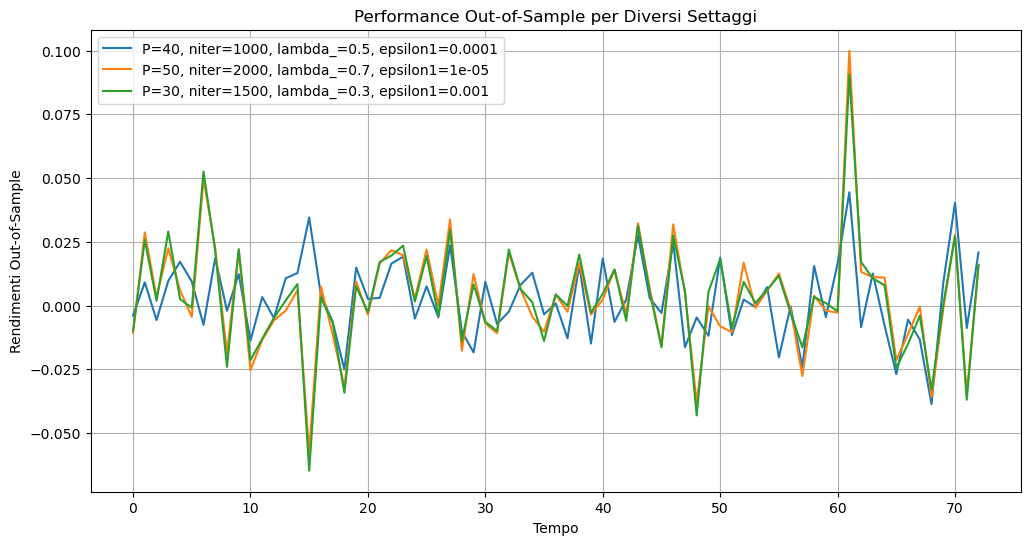


Performance Out-of-Sample Finali:
P=40, niter=1000, lambda_=0.5, epsilon1=0.0001
- Media: 0.0025, Varianza: 0.0002

P=50, niter=2000, lambda_=0.7, epsilon1=1e-05
- Media: 0.0029, Varianza: 0.0005

P=30, niter=1500, lambda_=0.3, epsilon1=0.001
- Media: 0.0031, Varianza: 0.0005



In [3]:
# Caricamento dei dati
data = pd.read_excel("log_returns.xlsx")
log_returns = data.iloc[:200, 1:].to_numpy()  # Primi 200 rendimenti logaritmici
out_of_sample_returns = data.iloc[200:, 1:].to_numpy()  # Rendimenti successivi (out-of-sample)

# Calcolo della media e della matrice di covarianza
mean_returns = np.mean(log_returns, axis=0)
cov_matrix = np.cov(log_returns, rowvar=False)

# Funzione obiettivo
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

# Funzione obiettivo per PSO
def mean_variance_objective(weights, mean_returns, cov_matrix, lambda_):
    port_return = portfolio_return(weights, mean_returns)
    port_variance = portfolio_variance(weights, cov_matrix)
    penalty = 1e3 * (np.abs(np.sum(weights) - 1) ** 2)  # Penalità per somma dei pesi
    return lambda_ * port_variance - (1 - lambda_) * port_return + penalty

# Ottimizzazione con PSO
def optimize_portfolio(mean_returns, cov_matrix, P, niter, lambda_, epsilon1):
    bounds = [(0, 1) for _ in range(len(mean_returns))]  # Vincolo: 0 <= pesi <= 1

    # Esecuzione PSO
    weights, _ = pso(
        mean_variance_objective,
        [0] * len(mean_returns),  # Limite inferiore
        [1] * len(mean_returns),  # Limite superiore
        args=(mean_returns, cov_matrix, lambda_),
        swarmsize=P, maxiter=niter, minstep=epsilon1, debug=False
    )
    return weights

# Parametri di ottimizzazione
settings = [
    {"P": 40, "niter": 1000, "lambda_": 0.5, "epsilon1": 1e-4},
    {"P": 50, "niter": 2000, "lambda_": 0.7, "epsilon1": 1e-5},
    {"P": 30, "niter": 1500, "lambda_": 0.3, "epsilon1": 1e-3},
]

# Risultati per i diversi settaggi
results = []

for config in settings:
    P = config["P"]
    niter = config["niter"]
    lambda_ = config["lambda_"]
    epsilon1 = config["epsilon1"]

# Ottimizzazione del portafoglio
    best_weights = optimize_portfolio(mean_returns, cov_matrix, P, niter, lambda_, epsilon1)

# Calcolo delle performance out-of-sample
    out_sample_returns = np.dot(out_of_sample_returns, best_weights)
    mean_out_sample = np.mean(out_sample_returns)
    var_out_sample = np.var(out_sample_returns)

# Salvataggio dei risultati
    results.append({
        "settaggio": f"P={P}, niter={niter}, lambda_={lambda_}, epsilon1={epsilon1}",
        "weights": best_weights,
        "mean_out_sample": mean_out_sample,
        "var_out_sample": var_out_sample,
        "out_sample_returns": out_sample_returns
    })


    print(f"\nSettaggio: P={P}, niter={niter}, lambda_={lambda_}, epsilon1={epsilon1}")
    print(f"- Media rendimento out-of-sample: {mean_out_sample:.4f}")
    print(f"- Varianza rendimento out-of-sample: {var_out_sample:.4f}")

# Visualizzazione delle performance out-of-sample
plt.figure(figsize=(12, 6))

for result in results:
    plt.plot(result["out_sample_returns"], label=result["settaggio"])

# Grafico
plt.xlabel("Tempo")
plt.ylabel("Rendimenti Out-of-Sample")
plt.title("Performance Out-of-Sample per Diversi Settaggi")
plt.legend()
plt.grid()
plt.show()

# Riepilogo dei risultati finali
print("\nPerformance Out-of-Sample Finali:")
for result in results:
    print(result["settaggio"])
    print(f"- Media: {result['mean_out_sample']:.4f}, Varianza: {result['var_out_sample']:.4f}\n")

Stopping search: Swarm best position change less than 1e-08

Settaggio: P=40, niter=1000, K=1.49618, epsilon1=0.0001
Portafoglio ottimale: [0.28213488 0.00038864 0.17259613 0.20286767 0.02236437 0.00074226
 0.2868551  0.03205095]
Fitness migliore: 24.557392788481398
Somma percentuali vincolo: -2.172704016700777e-09
Redditività vincolo: 0.0024557126423379863
Non negatività vincolo: 0.0


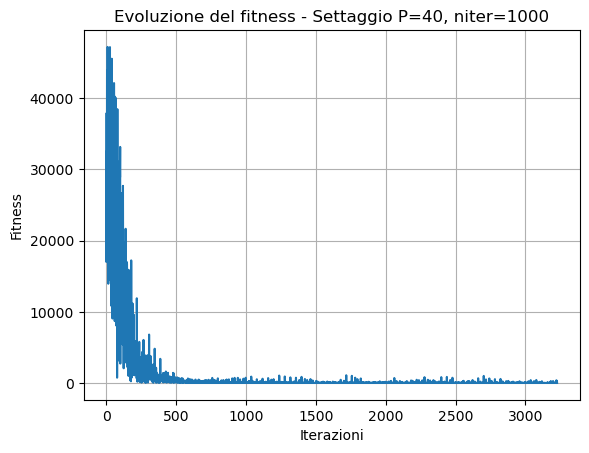

Stopping search: Swarm best position change less than 1e-08

Settaggio: P=50, niter=2000, K=1.2, epsilon1=1e-05
Portafoglio ottimale: [0.0058656  0.02770507 0.58184159 0.01170633 0.10779142 0.1829942
 0.04237451 0.03972127]
Fitness migliore: 203.5216858538234
Somma percentuali vincolo: 1.0494427549190277e-10
Redditività vincolo: 0.0020352120996512666
Non negatività vincolo: 0.0


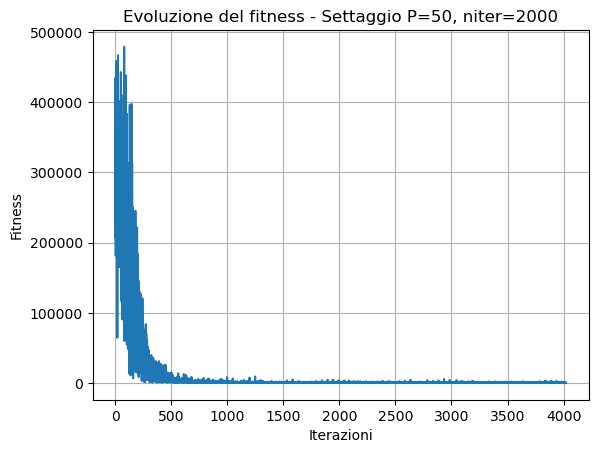

Stopping search: Swarm best position change less than 1e-08

Settaggio: P=30, niter=1500, K=2.0, epsilon1=0.001
Portafoglio ottimale: [4.50617606e-01 4.41850643e-02 1.64969094e-01 0.00000000e+00
 1.53066649e-01 1.33997361e-01 5.30310689e-02 1.33166411e-04]
Fitness migliore: 1.9871367260731958
Somma percentuali vincolo: 9.915492871215292e-09
Redditività vincolo: 0.001986851493476192
Non negatività vincolo: 0.0


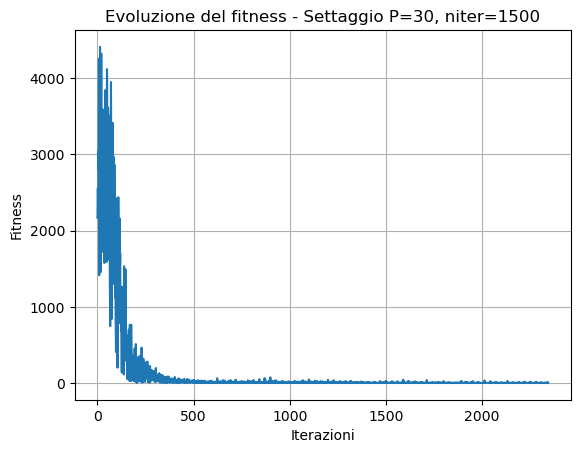

In [19]:
# Caricamento dei dati
data = pd.read_excel("log_returns.xlsx", sheet_name="Sheet1")
data = data.iloc[:200, 1:].values  # Primi 200 rendimenti logaritmici, esclusa la colonna delle date

# Calcolo della media e della matrice di covarianza
mean_returns = np.mean(data, axis=0)
cov_matrix = np.cov(data, rowvar=False)

# Parametri
annual_return_target = 0.07
pi = (1 + 0.07)**(1/252) - 1

# Funzione obiettivo
def objective(weights):
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_mean = np.dot(weights, mean_returns)
    penalty = (abs(sum(weights) - 1) +  # Vincolo di bilancio
               abs(portfolio_mean - pi) +  # Vincolo di redditività
               sum(np.maximum(0, -weights)))  # Vincolo di non negatività
    return portfolio_variance + penalty / epsilon1

# Vincoli
lb = [0] * len(mean_returns)  # Limite inferiore (x_i >= 0)
ub = [1] * len(mean_returns)  # Limite superiore

# Parametri PSO
settings = [
    {"P": 40, "niter": 1000, "K": 1.49618, "epsilon1": 1e-4},
    {"P": 50, "niter": 2000, "K": 1.2, "epsilon1": 1e-5},
    {"P": 30, "niter": 1500, "K": 2.0, "epsilon1": 1e-3},
]

# Iterazione per diversi settaggi
for config in settings:
    P = config["P"]
    niter = config["niter"]
    K = config["K"]
    epsilon1 = config["epsilon1"]

    fitness_history = []  # Evoluzione del fitness

    def objective_with_logging(weights):
        fitness = objective(weights)
        fitness_history.append(fitness)
        return fitness

# Ottimizzazione PSO
    best_weights, best_fitness = pso(objective_with_logging, lb, ub, swarmsize=P, maxiter=niter)

    print(f"\nSettaggio: P={P}, niter={niter}, K={K}, epsilon1={epsilon1}")
    print("Portafoglio ottimale:", best_weights)
    print("Fitness migliore:", best_fitness)
    print("Somma percentuali vincolo:", sum(best_weights) - 1)
    print("Redditività vincolo:", np.dot(best_weights, mean_returns) - pi)
    print("Non negatività vincolo:", sum(np.maximum(0, -best_weights)))

# Grafico della funzione di fitness
    plt.figure()
    plt.plot(fitness_history)
    plt.title(f"Evoluzione del fitness - Settaggio P={P}, niter={niter}")
    plt.xlabel("Iterazioni")
    plt.ylabel("Fitness")
    plt.grid()
    plt.show()


Stopping search: Swarm best position change less than 1e-08

Settaggio: P=40, niter=1000, epsilon1=0.0001
- Media rendimento out-of-sample: 0.0023
- Varianza rendimento out-of-sample: 0.0004
Stopping search: Swarm best position change less than 1e-08

Settaggio: P=50, niter=2000, epsilon1=1e-05
- Media rendimento out-of-sample: 0.0046
- Varianza rendimento out-of-sample: 0.0003
Stopping search: Swarm best position change less than 1e-08

Settaggio: P=30, niter=1500, epsilon1=0.001
- Media rendimento out-of-sample: 0.0021
- Varianza rendimento out-of-sample: 0.0010


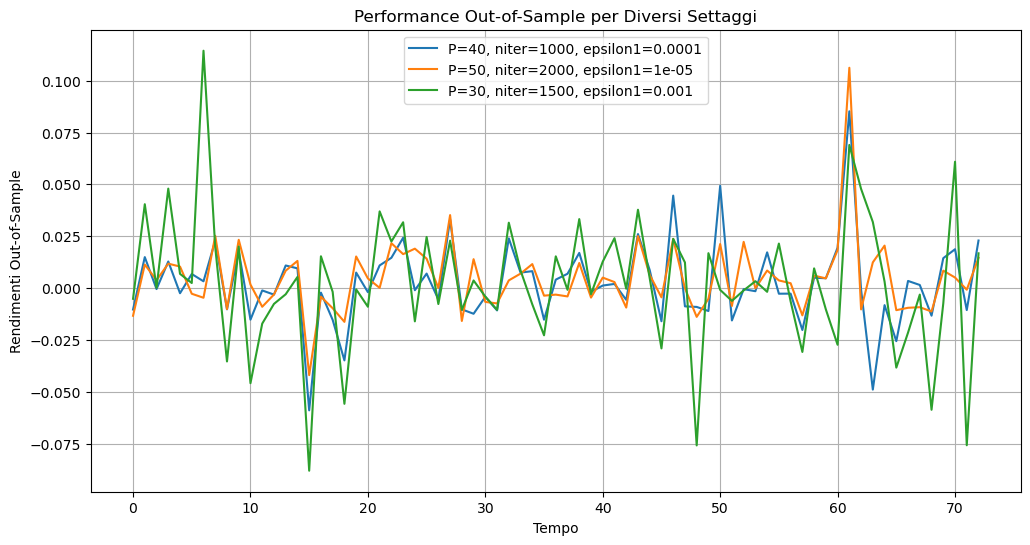


Performance Out-of-Sample Finali:
P=40, niter=1000, epsilon1=0.0001
- Media: 0.0023, Varianza: 0.0004

P=50, niter=2000, epsilon1=1e-05
- Media: 0.0046, Varianza: 0.0003

P=30, niter=1500, epsilon1=0.001
- Media: 0.0021, Varianza: 0.0010



In [17]:
# Caricamento dei dati
data = pd.read_excel("log_returns.xlsx")
log_returns = data.iloc[:200, 1:].to_numpy()  # Primi 200 rendimenti logaritmici
out_of_sample_returns = data.iloc[200:, 1:].to_numpy()  # Rendimenti successivi (out-of-sample)

# Calcolo della media e della matrice di covarianza
mean_returns = np.mean(log_returns, axis=0)
cov_matrix = np.cov(log_returns, rowvar=False)

# Parametri di ottimizzazione
annual_return_target = 0.07  # Rendimento annualizzato target
pi = (1 + annual_return_target) ** (1 / 252) - 1  # Rendimento giornaliero target

# Funzione obiettivo
def objective(weights):
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_mean = np.dot(weights, mean_returns)
    penalty = (abs(sum(weights) - 1) +  # Vincolo di bilancio
               abs(portfolio_mean - pi) +  # Vincolo di redditività
               sum(np.maximum(0, -weights)))  # Vincolo di non negatività
    return portfolio_variance + penalty / epsilon1

# Vincoli per i pesi
lb = [0] * len(mean_returns)  # Limite inferiore (pesi >= 0)
ub = [1] * len(mean_returns)  # Limite superiore (pesi <= 1)

# Parametri PSO
settings = [
    {"P": 40, "niter": 1000, "epsilon1": 1e-4},
    {"P": 50, "niter": 2000, "epsilon1": 1e-5},
    {"P": 30, "niter": 1500, "epsilon1": 1e-3},
]

# Risultati per i tre settaggi
results = [] 

for config in settings:
    P = config["P"]
    niter = config["niter"]
    epsilon1 = config["epsilon1"]

# Fitness
    fitness_history = []

    def objective_with_logging(weights):
        fitness = objective(weights)
        fitness_history.append(fitness)
        return fitness

# Ottimizzazione PSO
    best_weights, best_fitness = pso(objective_with_logging, lb, ub, swarmsize=P, maxiter=niter)

# Calcolo delle performance out-of-sample
    out_sample_returns = np.dot(out_of_sample_returns, best_weights)
    mean_out_sample = np.mean(out_sample_returns)
    var_out_sample = np.var(out_sample_returns)

    results.append({
        "settaggio": f"P={P}, niter={niter}, epsilon1={epsilon1}",
        "weights": best_weights,
        "mean_out_sample": mean_out_sample,
        "var_out_sample": var_out_sample,
        "out_sample_returns": out_sample_returns
    })

    print(f"\nSettaggio: P={P}, niter={niter}, epsilon1={epsilon1}")
    print(f"- Media rendimento out-of-sample: {mean_out_sample:.4f}")
    print(f"- Varianza rendimento out-of-sample: {var_out_sample:.4f}")

# Visualizzazione delle performance out-of-sample
plt.figure(figsize=(12, 6))

for result in results:
    plt.plot(result["out_sample_returns"], label=result["settaggio"])

# Personalizza il grafico
plt.xlabel("Tempo")
plt.ylabel("Rendimenti Out-of-Sample")
plt.title("Performance Out-of-Sample per Diversi Settaggi")
plt.legend()
plt.grid()
plt.show()

# Riepilogo dei risultati finali
print("\nPerformance Out-of-Sample Finali:")
for result in results:
    print(result["settaggio"])
    print(f"- Media: {result['mean_out_sample']:.4f}, Varianza: {result['var_out_sample']:.4f}\n")


In [15]:
# Caricamento dei dati
data = pd.read_excel("log_returns.xlsx")
log_returns = data.iloc[:, 1:]  # Escludi la colonna di date

# Livello di confidenza per VaR ed ES
confidence_level = 0.95

# Funzioni per calcolare VaR ed ES
def calculate_var(data, confidence=0.95):
    """
    Calcola il Value at Risk (VaR) per una data serie temporale.
    """
    return np.percentile(data, (1 - confidence) * 100)

def calculate_es(data, confidence=0.95):
    """
    Calcola l'Expected Shortfall (ES) per una data serie temporale.
    """
    var = calculate_var(data, confidence)
    return data[data <= var].mean()

results = {}

for column in log_returns.columns:
    series = log_returns[column].dropna().to_numpy()
    
# Calcolo di VaR ed ES
    var = calculate_var(series, confidence_level)
    es = calculate_es(series, confidence_level)
    
    results[column] = {
        "VaR": var,
        "ES": es
    }

# Visualizzazione dei risultati
results_df = pd.DataFrame(results).T
results_df.columns = ["VaR", "ES"]
print(results_df)


           VaR        ES
AIT  -0.025058 -0.033640
FLR  -0.027038 -0.054079
FN   -0.050786 -0.080621
FTAI -0.031520 -0.053859
INSM -0.041664 -0.051989
MLI  -0.023798 -0.034279
PCVX -0.037116 -0.052591
SFM  -0.024619 -0.032388


Criterio Media-VaR (attività ordinate):
          Mean       VaR        ES
FTAI  0.006135 -0.031520 -0.053859
SFM   0.004513 -0.024619 -0.032388
INSM  0.003980 -0.041664 -0.051989
MLI   0.003521 -0.023798 -0.034279
PCVX  0.002321 -0.037116 -0.052591
AIT   0.002055 -0.025058 -0.033640
FLR   0.001746 -0.027038 -0.054079
FN    0.001263 -0.050786 -0.080621

Criterio Media-ES (attività ordinate):
          Mean       VaR        ES
FTAI  0.006135 -0.031520 -0.053859
SFM   0.004513 -0.024619 -0.032388
INSM  0.003980 -0.041664 -0.051989
MLI   0.003521 -0.023798 -0.034279
PCVX  0.002321 -0.037116 -0.052591
AIT   0.002055 -0.025058 -0.033640
FLR   0.001746 -0.027038 -0.054079
FN    0.001263 -0.050786 -0.080621


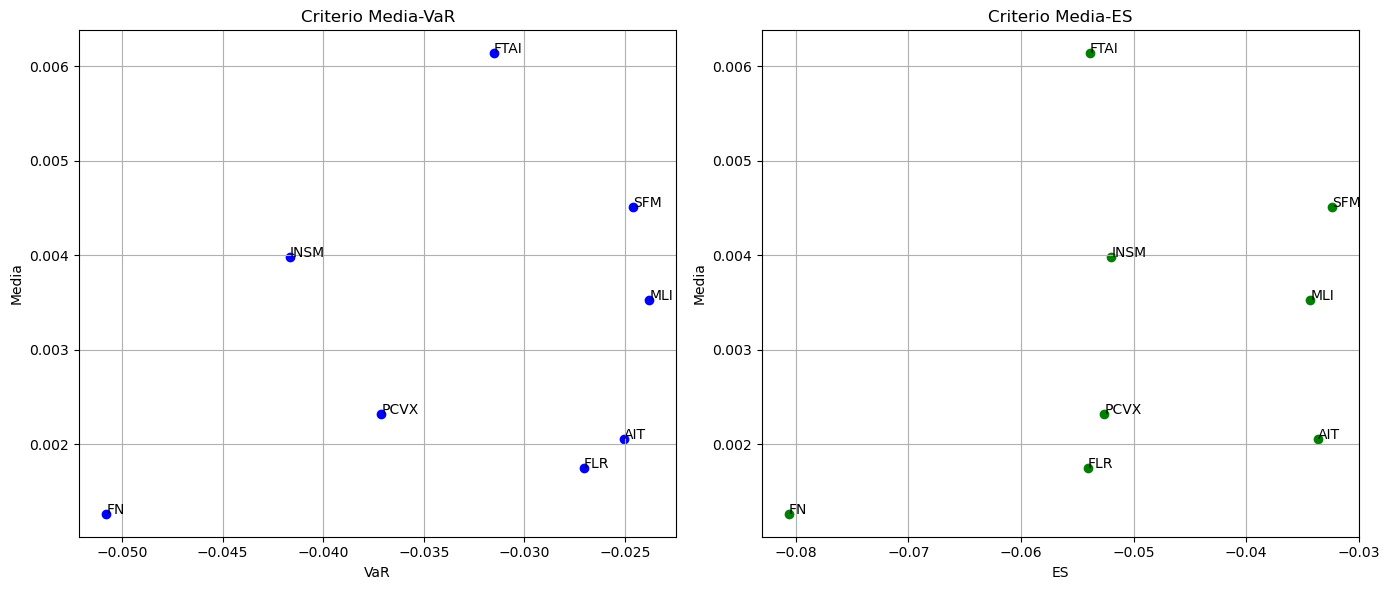

In [13]:
# Caricamento dei dati
data = pd.read_excel("log_returns.xlsx")
log_returns = data.iloc[:, 1:]  # Escludi la colonna di date

# Livello di confidenza per VaR ed ES
confidence_level = 0.95

# Funzioni per calcolare VaR ed ES
def calculate_var(data, confidence=0.95):
    return np.percentile(data, (1 - confidence) * 100)

def calculate_es(data, confidence=0.95):
    var = calculate_var(data, confidence)
    return data[data <= var].mean()

# Calcolo dei rendimenti medi, VaR ed ES
results = {}
for column in log_returns.columns:
    series = log_returns[column].dropna().to_numpy()
    mean = np.mean(series)
    var = calculate_var(series, confidence_level)
    es = calculate_es(series, confidence_level)
    
    results[column] = {
        "Mean": mean,
        "VaR": var,
        "ES": es
    }

# Risultati in un DataFrame
results_df = pd.DataFrame(results).T  # Trasformazione in DataFrame
results_df.columns = ["Mean", "VaR", "ES"]

# Criterio media-VaR
efficient_media_var = results_df.sort_values(by=["Mean", "VaR"], ascending=[False, True])

# Criterio media-ES
efficient_media_es = results_df.sort_values(by=["Mean", "ES"], ascending=[False, True])

# Output dei risultati
print("Criterio Media-VaR (attività ordinate):")
print(efficient_media_var)

print("\nCriterio Media-ES (attività ordinate):")
print(efficient_media_es)

plt.figure(figsize=(14, 6))

# Grafico Media-VaR
plt.subplot(1, 2, 1)
plt.scatter(results_df["VaR"], results_df["Mean"], color="blue", label="Attività")
plt.xlabel("VaR")
plt.ylabel("Media")
plt.title("Criterio Media-VaR")
plt.grid()
for i, txt in enumerate(results_df.index):
    plt.annotate(txt, (results_df["VaR"].iloc[i], results_df["Mean"].iloc[i]))

# Grafico Media-ES
plt.subplot(1, 2, 2)
plt.scatter(results_df["ES"], results_df["Mean"], color="green", label="Attività")
plt.xlabel("ES")
plt.ylabel("Media")
plt.title("Criterio Media-ES")
plt.grid()
for i, txt in enumerate(results_df.index):
    plt.annotate(txt, (results_df["ES"].iloc[i], results_df["Mean"].iloc[i]))

plt.tight_layout()
plt.show()
